In [1]:
import pandas as pd

# Load  dataset 
df = pd.read_csv(r'..\Data\data.csv')
# Group by CustomerId and find if any fraudulent transactions exist for each customer
df['RiskLabel'] = df.groupby('CustomerId')['FraudResult'].transform(lambda x: 'high-risk' if x.max() == 1 else 'low-risk')

# Check the result
df[['CustomerId', 'FraudResult', 'RiskLabel']].drop_duplicates().head()



,CustomerId,FraudResult,RiskLabel
0,CustomerId_4406,0,low-risk
2,CustomerId_4683,0,low-risk
3,CustomerId_988,0,low-risk
5,CustomerId_1432,0,low-risk
6,CustomerId_2858,0,low-risk


In [2]:
#Overview of the Data
# Show the basic structure of the dataset (rows, columns, data types)
df_info = df.info()
df_head = df.head()

# Output
print(df_info)
print(df_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [3]:
#Summary Statistics for Numerical Features

# Summary statistics for numerical columns
summary_stats = df.describe()

# Checking for missing values
missing_values = df.isnull().sum()

# Extracting categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64']).columns

# Output
print(summary_stats)
print(missing_values)
print(categorical_cols)
print(numerical_cols)



       CountryCode        Amount         Value  PricingStrategy   FraudResult
count      95662.0  9.566200e+04  9.566200e+04     95662.000000  95662.000000
mean         256.0  6.717846e+03  9.900584e+03         2.255974      0.002018
std            0.0  1.233068e+05  1.231221e+05         0.732924      0.044872
min          256.0 -1.000000e+06  2.000000e+00         0.000000      0.000000
25%          256.0 -5.000000e+01  2.750000e+02         2.000000      0.000000
50%          256.0  1.000000e+03  1.000000e+03         2.000000      0.000000
75%          256.0  2.800000e+03  5.000000e+03         2.000000      0.000000
max          256.0  9.880000e+06  9.880000e+06         4.000000      1.000000
TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount      

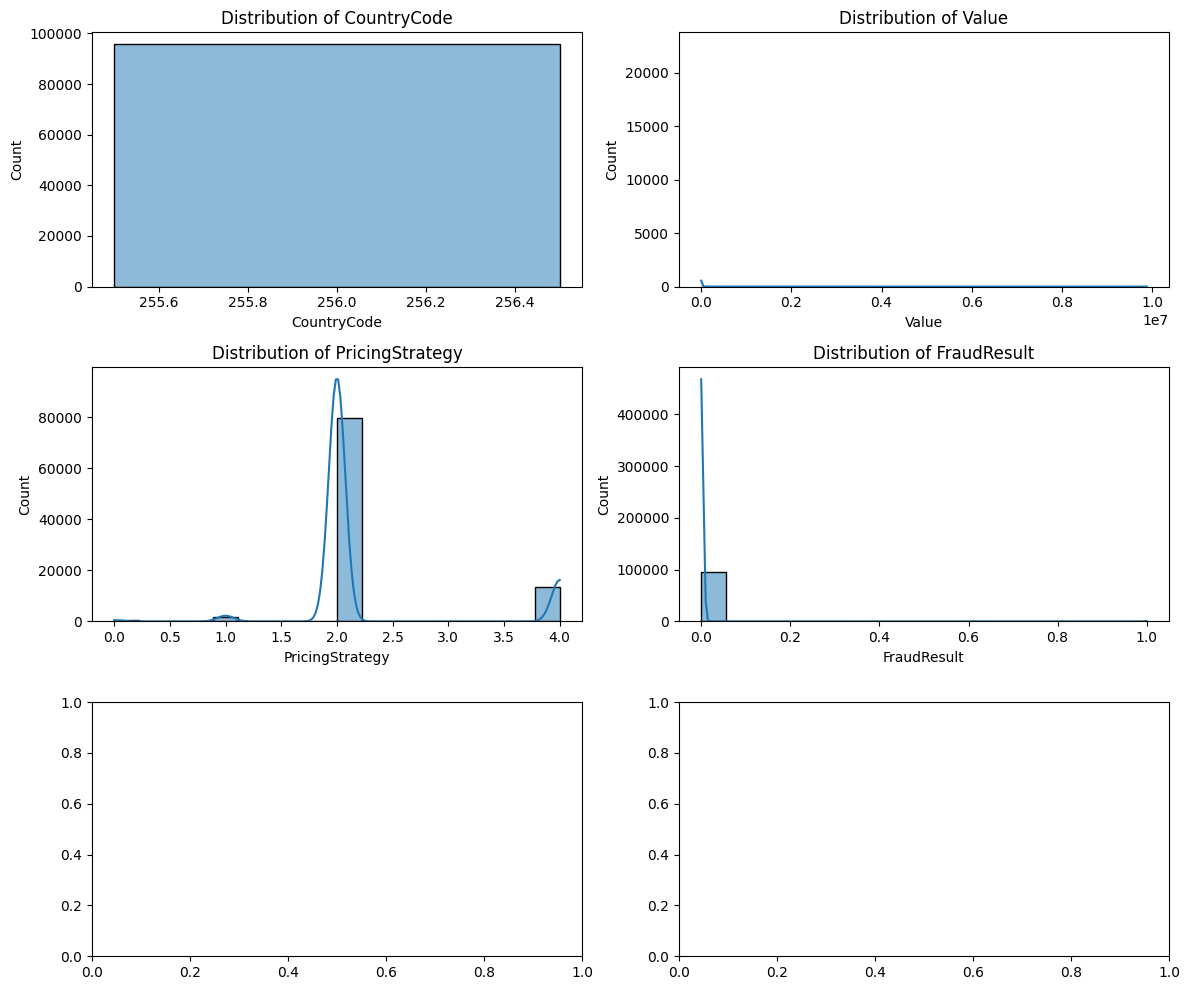

In [4]:
#Distribution of Numerical Features
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot grid for numerical features
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot distribution for each numerical feature
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

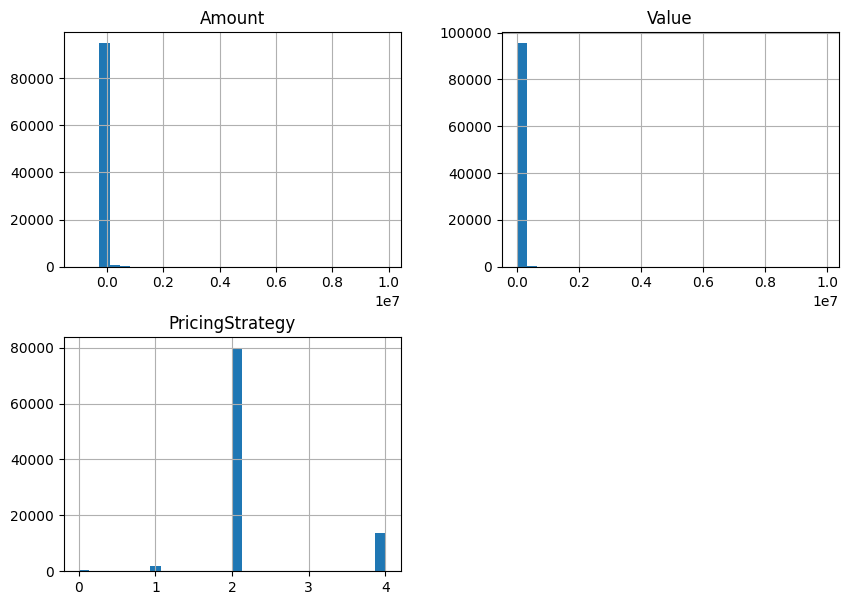

In [5]:

df[['Amount', 'Value', 'PricingStrategy']].hist(bins=30, figsize=(10, 7))
plt.show()

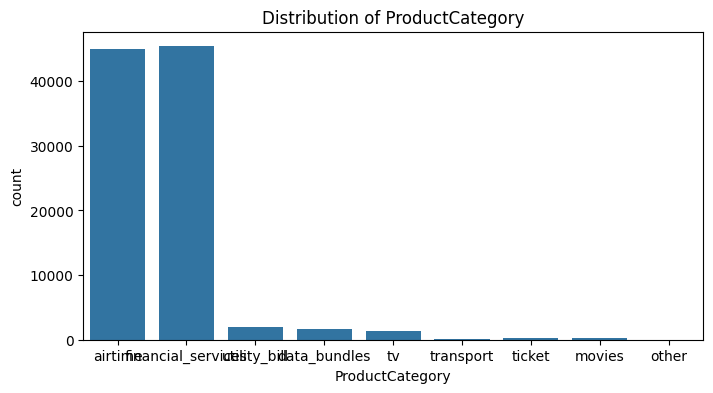

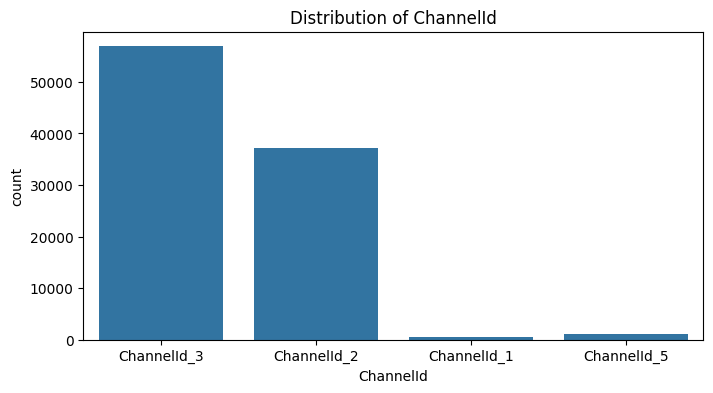

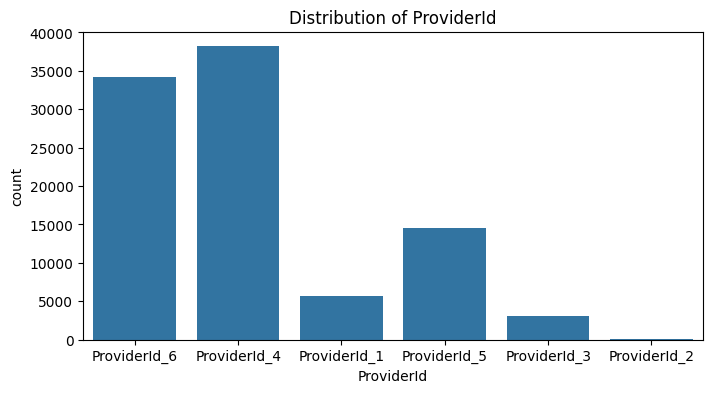

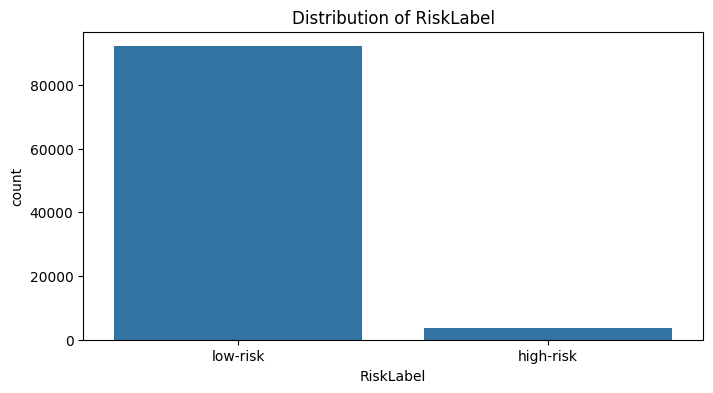

In [6]:
#Distribution of Categorical Features
import seaborn as sns

categorical_columns = ['ProductCategory', 'ChannelId', 'ProviderId', 'RiskLabel']
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()


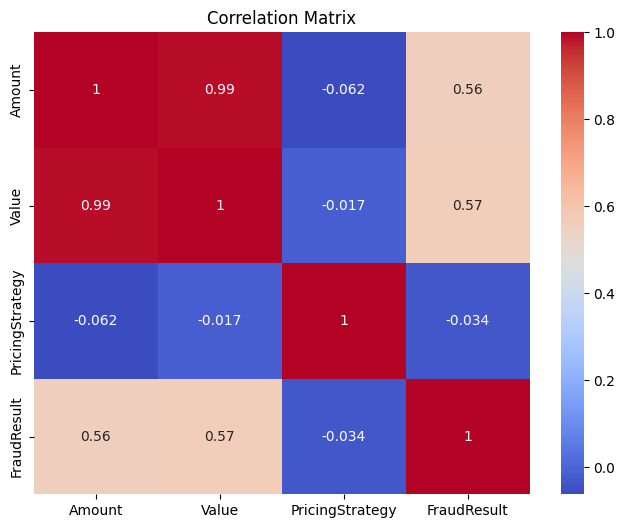

In [7]:
#Correlation Analysis
import seaborn as sns

correlation_matrix = df[['Amount', 'Value', 'PricingStrategy', 'FraudResult']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


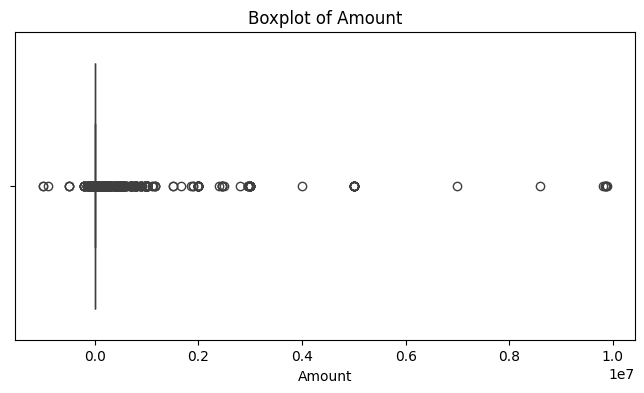

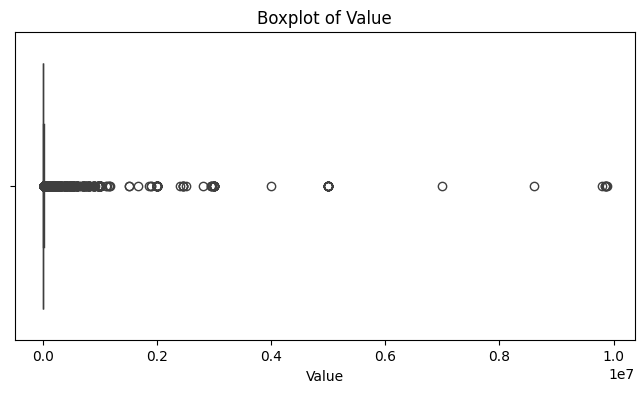

In [8]:
#Outlier Detection
for col in ['Amount', 'Value']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()


In [9]:
#Aggregate Features Creation
# Aggregate features to create based on customer transactions
# Ensure that the 'CustomerId' is present in the dataset for grouping

# Group by 'CustomerId' to calculate aggregated features
agg_features = df.groupby('CustomerId').agg(
    TotalTransactionAmount=('Amount', 'sum'),             # Sum of all transaction amounts
    AverageTransactionAmount=('Amount', 'mean'),          # Average transaction amount
    TransactionCount=('Amount', 'count'),                 # Number of transactions
    StdDevTransactionAmount=('Amount', 'std')             # Standard deviation of transaction amounts
).reset_index()

# Display the newly created aggregate features
agg_features.head()



,CustomerId,TotalTransactionAmount,AverageTransactionAmount,TransactionCount,StdDevTransactionAmount
0,CustomerId_1,-10000.0,-10000.000000,1,NaN
1,CustomerId_10,-10000.0,-10000.000000,1,NaN
2,CustomerId_1001,20000.0,4000.000000,5,6558.963333
3,CustomerId_1002,4225.0,384.090909,11,560.498966
4,CustomerId_1003,20000.0,3333.333333,6,6030.478146


In [10]:
#Handling Negative Transactions
# Separate positive and negative transactions
df['TransactionType'] = df['Amount'].apply(lambda x: 'Refund' if x < 0 else 'Purchase')

# Aggregate for both positive and negative transactions
agg_features = df.groupby('CustomerId').agg(
    TotalTransactionAmount=('Amount', 'sum'),             # Sum of all transaction amounts
    TotalRefundAmount=('Amount', lambda x: x[x < 0].sum()),  # Sum of negative (refund) amounts
    TotalPurchaseAmount=('Amount', lambda x: x[x > 0].sum()),  # Sum of positive (purchase) amounts
    AverageTransactionAmount=('Amount', 'mean'),          # Average transaction amount
    TransactionCount=('Amount', 'count'),                 # Number of transactions
    StdDevTransactionAmount=('Amount', 'std')             # Standard deviation of transaction amounts
).reset_index()

# Replace NaN values in StdDevTransactionAmount with 0
agg_features['StdDevTransactionAmount'].fillna(0, inplace=True)

# Output the updated feature set
agg_features.head()


C:\Users\eep\AppData\Local\Temp\ipykernel_26560\4106193257.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agg_features['StdDevTransactionAmount'].fillna(0, inplace=True)


,CustomerId,TotalTransactionAmount,TotalRefundAmount,TotalPurchaseAmount,AverageTransactionAmount,TransactionCount,StdDevTransactionAmount
0,CustomerId_1,-10000.0,-10000.0,0.0,-10000.000000,1,0.000000
1,CustomerId_10,-10000.0,-10000.0,0.0,-10000.000000,1,0.000000
2,CustomerId_1001,20000.0,-5200.0,25200.0,4000.000000,5,6558.963333
3,CustomerId_1002,4225.0,-275.0,4500.0,384.090909,11,560.498966
4,CustomerId_1003,20000.0,-6000.0,26000.0,3333.333333,6,6030.478146


In [11]:
#Validate Results
# Check for any remaining missing values
missing_values_after = agg_features.isnull().sum()
print(missing_values_after)

# Display the cleaned data
agg_features.head()


CustomerId                  0
TotalTransactionAmount      0
TotalRefundAmount           0
TotalPurchaseAmount         0
AverageTransactionAmount    0
TransactionCount            0
StdDevTransactionAmount     0
dtype: int64


,CustomerId,TotalTransactionAmount,TotalRefundAmount,TotalPurchaseAmount,AverageTransactionAmount,TransactionCount,StdDevTransactionAmount
0,CustomerId_1,-10000.0,-10000.0,0.0,-10000.000000,1,0.000000
1,CustomerId_10,-10000.0,-10000.0,0.0,-10000.000000,1,0.000000
2,CustomerId_1001,20000.0,-5200.0,25200.0,4000.000000,5,6558.963333
3,CustomerId_1002,4225.0,-275.0,4500.0,384.090909,11,560.498966
4,CustomerId_1003,20000.0,-6000.0,26000.0,3333.333333,6,6030.478146


In [12]:
#2.	Extract Features #Example:
#Transaction Hour: The hour of the day when the transaction occurred.
#Transaction Day: The day of the month when the transaction occurred.
#Transaction Month: The month when the transaction occurred.
#Transaction Year: The year when the transaction occurred.
# Ensure that 'Date' column is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionStartTime'])

# Extract transaction hour, day, month, and year
df['TransactionHour'] = df['TransactionDate'].dt.hour    # Hour of the transaction
df['TransactionDay'] = df['TransactionDate'].dt.day      # Day of the month
df['TransactionMonth'] = df['TransactionDate'].dt.month  # Month of the transaction
df['TransactionYear'] = df['TransactionDate'].dt.year    # Year of the transaction

# Display the updated dataset with new features
df[['CustomerId', 'TransactionDate', 'TransactionHour', 'TransactionDay', 'TransactionMonth', 'TransactionYear']].head()


,CustomerId,TransactionDate,TransactionHour,TransactionDay,TransactionMonth,TransactionYear
0,CustomerId_4406,2018-11-15 02:18:49+00:00,2,15,11,2018
1,CustomerId_4406,2018-11-15 02:19:08+00:00,2,15,11,2018
2,CustomerId_4683,2018-11-15 02:44:21+00:00,2,15,11,2018
3,CustomerId_988,2018-11-15 03:32:55+00:00,3,15,11,2018
4,CustomerId_988,2018-11-15 03:34:21+00:00,3,15,11,2018


In [13]:
#3.	Encode Categorical Variables
#Convert categorical variables into numerical format by using:
#One-Hot Encoding: Converts categorical values into binary vectors.
#Label Encoding: Assigns a unique integer to each category.
# Check data types in the dataframe
print(df.dtypes)

TransactionId                        object
BatchId                              object
AccountId                            object
SubscriptionId                       object
CustomerId                           object
CurrencyCode                         object
CountryCode                           int64
ProviderId                           object
ProductId                            object
ProductCategory                      object
ChannelId                            object
Amount                              float64
Value                                 int64
TransactionStartTime                 object
PricingStrategy                       int64
FraudResult                           int64
RiskLabel                            object
TransactionType                      object
TransactionDate         datetime64[ns, UTC]
TransactionHour                       int32
TransactionDay                        int32
TransactionMonth                      int32
TransactionYear                 

In [14]:
#One-Hot Encoding
#For categorical variables that do not have an ordinal relationship, use One-Hot Encoding. This creates binary columns for each category.
# Perform One-Hot Encoding for non-ordinal categorical variables
categorical_columns_to_encode = ['ProductCategory', 'ProviderId', 'TransactionType']
df_one_hot_encoded = pd.get_dummies(df, columns=categorical_columns_to_encode, drop_first=True)

# Display the shape of the new dataframe
print(df_one_hot_encoded.shape)

# Display the first few rows of the updated dataframe
print(df_one_hot_encoded.head())


(95662, 34)
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode     ProductId    ChannelId  \
0  CustomerId_4406          UGX          256  ProductId_10  ChannelId_3   
1  CustomerId_4406          UGX          256   ProductId_6  ChannelId_2   
2  CustomerId_4683          UGX          256   ProductId_1  ChannelId_3   
3   CustomerId_988          UGX          256  ProductId_21  ChannelId_3   
4   CustomerId_988          UGX          256   ProductId_6  ChannelId_2   

    Amount  ...  ProductCategory_ticket ProductCategory_transp

In [15]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Perform Label Encoding on the 'RiskLabel' column
df_one_hot_encoded['EncodedRiskLabel'] = label_encoder.fit_transform(df_one_hot_encoded['RiskLabel'])

# Display the first few rows to see the changes
print(df_one_hot_encoded[['RiskLabel', 'EncodedRiskLabel']].head())


  RiskLabel  EncodedRiskLabel
0  low-risk                 1
1  low-risk                 1
2  low-risk                 1
3  low-risk                 1
4  low-risk                 1


In [16]:
# Display the mapping of labels to their encoded values
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'high-risk': 0, 'low-risk': 1}


In [17]:
#4.	Handle Missing Values
#	Use imputation or Removal to handle missing values
#	Imputation: Filling missing values with mean, median, mode, or using more methods like KNN imputation.
# Removal: Removing rows or columns with missing values if they are few.
# Check for missing values
missing_values = df_one_hot_encoded.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [31]:
#5.	Normalize/Standardize Numerical Features
#Normalization and standardization are scaling techniques used to bring all numerical features onto a similar scale.
#Normalization: Scales the data to a range of [0, 1].
#Standardization: Scales the data to have a mean of 0 and a standard deviation of 1.
#Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler for normalization
scaler = MinMaxScaler()

# Select numerical columns for normalization
num_cols = df_one_hot_encoded.select_dtypes(include=['float64', 'int64']).columns

# Normalize the selected numerical columns
df_one_hot_encoded[num_cols] = scaler.fit_transform(df_one_hot_encoded[num_cols])


In [32]:
#Standardization
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler for standardization
standard_scaler = StandardScaler()

# Standardize the selected numerical columns
df_one_hot_encoded[num_cols] = standard_scaler.fit_transform(df_one_hot_encoded[num_cols])


In [33]:
# Create instances of MinMaxScaler and StandardScaler
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Normalize the 'Amount' and 'Value' columns
df['Amount_Normalized'] = minmax_scaler.fit_transform(df[['Amount']])
df['Value_Normalized'] = minmax_scaler.fit_transform(df[['Value']])

# Standardize the 'Amount' and 'Value' columns
df['Amount_Standardized'] = standard_scaler.fit_transform(df[['Amount']])
df['Value_Standardized'] = standard_scaler.fit_transform(df[['Value']])

In [ ]:
from xverse

In [49]:
from woe import woe
# Calculate WOE and IV for categorical features (adjust column names as needed)
woe_iv = woe(df, ['Category', 'Channelid'], 'Fraud')

# Print the results
print(woe_iv)

ImportError: cannot import name 'woe' from 'woe' (d:\Data Science\10acadamy\plony_env\Lib\site-packages\woe\__init__.py)

Weight of Evidence (WOE) and Information Value (IV)
Weight of Evidence (WOE) is a technique used in credit scoring to transform categorical variables into a numerical format that captures the relationship between the independent variables and the dependent variable (target). Information Value (IV) quantifies the predictive power of the categorical feature based on the WOE.